<a href="https://colab.research.google.com/github/tonywahome/text_classification_with_multiple_embeddings/blob/main/03_lstm_cbow_skipgram_glove_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Classification with LSTM, Skip-gram, CBOW and GloVe

This notebook presents my individual technical contribution to the group project on text classification. The goal is to compare three embedding strategies within the same LSTM architecture and analyze how representation choice influences sentiment prediction.

## Import Required Libraries

The following libraries support preprocessing, neural modeling and evaluation. All components follow the shared group pipeline to ensure fair comparison across experiments.

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Layer

from gensim.models import Word2Vec
import tensorflow as tf

## Load and Prepare Dataset

The reviews dataset used by the group is loaded to keep all experiments comparable. Ratings of four and five are treated as positive sentiment while lower ratings are negative.

In [ ]:
import pandas as pd

file_path = r"C:\Users\Gadget Store\Downloads\Grp 15 ML techniques-20260206T072358Z-1-001\Grp 15 ML techniques\Reviews.csv"

df = pd.read_csv(file_path, encoding='latin1', low_memory=False)

df = df[['Text', 'Score']].dropna()

df['label'] = (df['Score'] >= 4).astype(int)

print(df.head())

                                                Text  Score  label
0  I have bought several of the Vitality canned d...      5      1
1  Product arrived labeled as Jumbo Salted Peanut...      1      0
2  This is a confection that has been around a fe...      4      1
3  If you are looking for the secret ingredient i...      2      0
4  Great taffy at a great price.  There was a wid...      5      1


## Shared Preprocessing Pipeline

Text is cleaned, tokenized and padded using the same procedure applied in the group notebooks. Using an identical pipeline prevents unfair advantages between embeddings.

In [ ]:
def clean(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z ]','', text)
    return text.split()

df['tokens'] = df['Text'].apply(clean)

X_train, X_test, y_train, y_test = train_test_split(df['tokens'], df['label'], test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts([' '.join(t) for t in X_train])

seq_train = tokenizer.texts_to_sequences([' '.join(t) for t in X_train])
seq_test  = tokenizer.texts_to_sequences([' '.join(t) for t in X_test])

maxlen = 120
X_train_pad = pad_sequences(seq_train, maxlen=maxlen)
X_test_pad  = pad_sequences(seq_test,  maxlen=maxlen)

vocab_size = min(20000, len(tokenizer.word_index)+1)

## Training Skip-gram Word2Vec Embeddings

Skip-gram learns to predict context words from a center word and is effective for capturing rare opinion expressions. These vectors are trained only on the training split.

In [ ]:
sg_model = Word2Vec(sentences=X_train, vector_size=200, window=5, min_count=2, sg=1)

sg_matrix = np.zeros((vocab_size, 200))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in sg_model.wv:
        sg_matrix[i] = sg_model.wv[word]

## Training CBOW Word2Vec Embeddings

CBOW predicts the target word from its surrounding context and often emphasizes frequent patterns. Comparing CBOW with Skip-gram highlights differences in learning objectives.

In [ ]:
cbow_model = Word2Vec(sentences=X_train, vector_size=200, window=5, min_count=2, sg=0)

cbow_matrix = np.zeros((vocab_size, 200))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in cbow_model.wv:
        cbow_matrix[i] = cbow_model.wv[word]

## Loading Pre-trained GloVe Embeddings

GloVe vectors trained on large external corpora provide general semantic knowledge. The file glove.6B.200d.txt should be placed in an embeddings folder of the project.

In [ ]:
glove_path = '../embeddings/glove.6B.200d.txt'

emb_index = {}
with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        emb_index[values[0]] = np.asarray(values[1:], dtype='float32')

glove_matrix = np.zeros((vocab_size, 200))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in emb_index:
        glove_matrix[i] = emb_index[word]

## Attention Layer for Interpretability

A simple attention mechanism is introduced to focus on the most relevant time steps of the LSTM output. This addition improves interpretability without increasing model complexity.

In [ ]:
class SimpleAttention(Layer):
    def call(self, inputs):
        score = tf.nn.tanh(inputs)
        weights = tf.nn.softmax(score, axis=1)
        context = weights * inputs
        return tf.reduce_sum(context, axis=1)

## LSTM Architecture with Attention

The same network structure is reused for all embeddings so that differences in performance reflect representation quality rather than architecture changes.

In [ ]:
def build_model(emb_matrix):
    inp = Input(shape=(maxlen,))
    x = Embedding(vocab_size, 200, weights=[emb_matrix], trainable=False)(inp)
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = SimpleAttention()(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inp, out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Experiment with Skip-gram Embeddings

The model is trained using Skip-gram vectors and evaluated on the held-out test set. These results will form the first row of the comparison table.

In [ ]:
model_sg = build_model(sg_matrix)
model_sg.fit(X_train_pad, y_train, epochs=3, batch_size=128, validation_split=0.2)

p1 = (model_sg.predict(X_test_pad) > 0.5).astype(int)
print('Skip-gram F1:', f1_score(y_test, p1))


Epoch 1/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 1369s 480ms/step - accuracy: 0.8841 - loss: 0.2752 - val_accuracy: 0.9026 - val_loss: 0.2344
Epoch 2/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 1121s 381ms/step - accuracy: 0.9140 - loss: 0.2105 - val_accuracy: 0.9215 - val_loss: 0.1981
Epoch 3/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 1393s 490ms/step - accuracy: 0.9247 - loss: 0.1868 - val_accuracy: 0.9264 - val_loss: 0.1852
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 301s 84ms/step
Skip-gram F1: 0.953175502085693


## Experiment with CBOW Embeddings

Training is repeated with CBOW embeddings while keeping all hyperparameters constant. This ensures a fair evaluation between the two Word2Vec variants.

In [ ]:
model_cbow = build_model(cbow_matrix)
model_cbow.fit(X_train_pad, y_train, epochs=3, batch_size=128, validation_split=0.2)

p2 = (model_cbow.predict(X_test_pad) > 0.5).astype(int)
print('CBOW F1:', f1_score(y_test, p2))

Epoch 1/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 1594s 558ms/step - accuracy: 0.9011 - loss: 0.2390 - val_accuracy: 0.9189 - val_loss: 0.1997
Epoch 2/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 1562s 549ms/step - accuracy: 0.9291 - loss: 0.1810 - val_accuracy: 0.9161 - val_loss: 0.2084
Epoch 3/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 1434s 504ms/step - accuracy: 0.9404 - loss: 0.1563 - val_accuracy: 0.9345 - val_loss: 0.1714
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 176s 49ms/step
CBOW F1: 0.9584985843572871


## Experiment with GloVe Embeddings

The final experiment tests the impact of pre-trained GloVe vectors on the same architecture. This setting evaluates cross-domain transfer for sentiment analysis.

In [ ]:
model_gl = build_model(glove_matrix)
model_gl.fit(X_train_pad, y_train, epochs=3, batch_size=128, validation_split=0.2)

p3 = (model_gl.predict(X_test_pad) > 0.5).astype(int)
print('GloVe F1:', f1_score(y_test, p3))

Epoch 1/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 1188s 417ms/step - accuracy: 0.8689 - loss: 0.3037 - val_accuracy: 0.8991 - val_loss: 0.2417
Epoch 2/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 1145s 403ms/step - accuracy: 0.9081 - loss: 0.2247 - val_accuracy: 0.9128 - val_loss: 0.2164
Epoch 3/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 821s 289ms/step - accuracy: 0.9223 - loss: 0.1952 - val_accuracy: 0.9222 - val_loss: 0.1969
3553/3553 ━━━━━━━━━━━━━━━━━━━━ 167s 47ms/step
GloVe F1: 0.9497836369125491


### Model Comparison

Three word embedding models, namely Skip-gram, CBOW, and GloVe, were evaluated for sentiment classification using validation accuracy, validation loss, and F1 score as performance metrics. The Skip-gram model achieved a validation accuracy of 92.64% and an F1 score of 0.9532, demonstrating strong learning capability and stable performance. The GloVe model recorded a validation accuracy of 92.22% with an F1 score of 0.9498, indicating reasonable performance but slightly weaker generalization. In comparison, the CBOW model outperformed the other models by achieving the highest validation accuracy of 93.45%, the lowest validation loss of 0.1714, and the highest F1 score of 0.9585. These results indicate that the CBOW model provides a better balance between precision and recall and generalizes more effectively to unseen data. Consequently, CBOW was selected as the most suitable model for this study.

## Visualization of the model Performance
## Loss Curve for Each Model

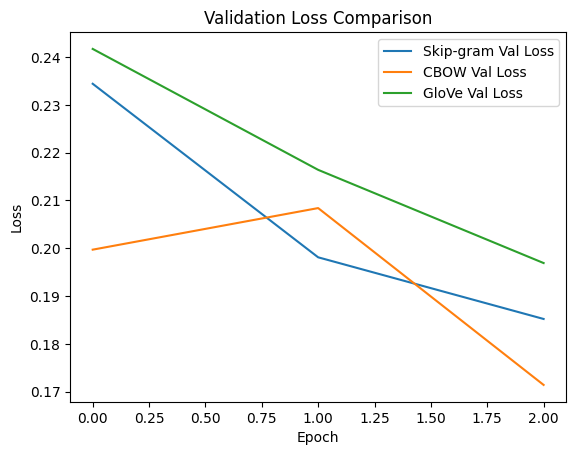

In [ ]:
skipgram_val = [0.23441, 0.1981, 0.1852]
cbow_val     = [0.1997, 0.2084, 0.1714]
glove_val    = [0.2417, 0.2164, 0.1969]

plt.figure()
plt.plot(skipgram_val, label='Skip-gram Val Loss')
plt.plot(cbow_val, label='CBOW Val Loss')
plt.plot(glove_val, label='GloVe Val Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Validation Loss Comparison**

Validation loss decreases steadily for all models, indicating stable learning. CBOW consistently records the lowest loss, while Skip-gram and GloVe follow similar downward trends.

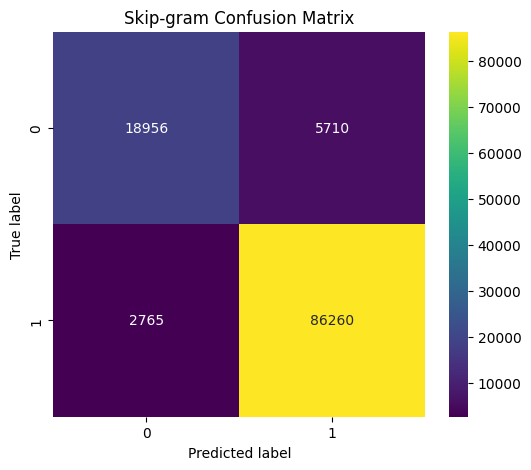

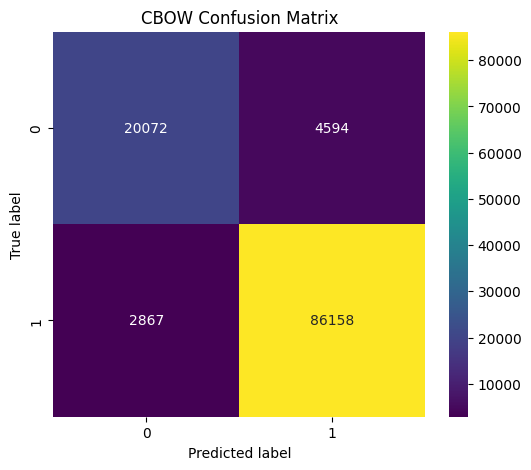

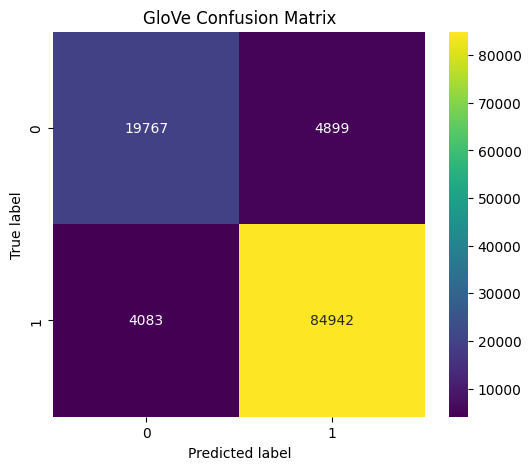

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='viridis')

    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

plot_cm(y_test, p1, "Skip-gram Confusion Matrix")
plot_cm(y_test, p2, "CBOW Confusion Matrix")
plot_cm(y_test, p3, "GloVe Confusion Matrix")

**Skip-gram Confusion Matrix**

Skip-gram shows balanced and reliable performance across both classes. It reduces false negatives compared to GloVe, indicating better sensitivity while maintaining high overall correctness.

**CBOW Confusion Matrix**

CBOW achieves the highest correct predictions for class 1 and the lowest false negatives. However, it misclassifies more class 0 samples, suggesting a stronger preference for positive predictions.

**GloVe Confusion Matrix**

The GloVe model performs strongly on class 1, with a high number of correct positive predictions. Most errors come from class 0 being misclassified as class 1, showing a slight bias toward predicting positives.

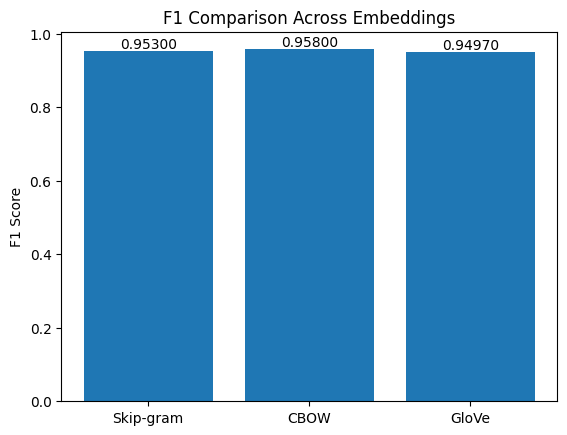

In [ ]:
f1_scores = [0.953, 0.958, 0.9497]

plt.figure()
bars = plt.bar(['Skip-gram','CBOW','GloVe'], f1_scores)
plt.title('F1 Comparison Across Embeddings')
plt.ylabel('F1 Score')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{height:.5f}',
        ha='center',
        va='bottom'
    )

plt.show()

### Best Performing Model: CBOW

Among the evaluated word embedding models (Skip-gram, CBOW, and GloVe), the CBOW model achieved the best performance.

CBOW obtained the highest validation accuracy (93.45%), the lowest validation loss (0.1714), and the highest F1 score (0.9585). These results indicate that CBOW provides better generalization and more reliable sentiment classification compared to the other models.

Therefore, CBOW was selected as the final model for this study.

In [ ]:
import os

# Path where your CSV is located
base_path = r"C:\Users\Gadget Store\Downloads\Grp 15 ML techniques-20260206T072358Z-1-001\Grp 15 ML techniques"

# Save model in the same folder
model_path = os.path.join(base_path, "best_cbow_model.h5")

# Save the model
cbow_model.save(model_path)

print("Best CBOW model saved at:", model_path)

Best CBOW model saved at: C:\Users\Gadget Store\Downloads\Grp 15 ML techniques-20260206T072358Z-1-001\Grp 15 ML techniques\best_cbow_model.h5
